<a href="https://colab.research.google.com/github/JoDeMiro/Keras/blob/main/08_Keras_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Bevezetés a TensorFlow Text Classification használatába.

Nem utolsó sorban azért készítem el ezt a notebookot mert elképesztően jó template.

Korábbi nagyon jó cikk:
https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras

# Basic Text Classification: Class(z) -> Text(tokens)

<table class="buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/JoDeMiro/Face" /><img src="https://github.com/JoDeMiro/Data/raw/main/Bucket/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Ebben a példában csak próba képpen szeretném bemutatni, hogyan lehet Tensorflow Keras API segítségével szövegeket oszályozni. Ami itt bemutatásra kerül a *One-Hot Encoding* a *Word2Vec* a *Tokenizáció* és a végén még az is, hogy lehet többféle bemenet alapján két különböző modelt tanítani úgy, hogy a klasszifikációban mindkettő részt vegyen.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [ ]:
from keras import backend as K

if K.backend() == "tensorflow":
    import tensorflow as tf
    device_name = tf.test.gpu_device_name()
    if device_name == '':
        device_name = "None"
    print('Using TensorFlow version:', tf.__version__, ', GPU:', device_name)

Using TensorFlow version: 2.7.0 , GPU: /device:GPU:0


Ebben a notebookban fogok egy nagy szöveghalmazt a Kagleről. A szöveges üzenetek alapján fogjuk becsülni az éftékelést, ami kategóriális és One-Hot encodoltá fogom alakítani mielött becsüljük. A költségfüggvény **soft-max** lesz.

A második részben nem csak a szöveges információk felhasználásával végzem a becslést, hanem kategóriális meta adatokkal is, amelyek szintén minden egyes rekordhoz hozzá vannak rendelve.

Végig a Keras Functiona API-t fogom használni a **Sequential** helyett, azért mert csak ennek segítségével lehet megcsinálni azt, hogy két különböző architechturáju modelt összekötök.


### Az adathalmaz
Az adatokat a Kaggleről lehet letölteni, de az adatok nem fértek be a rendszer memóriájába ezért manuálisan letöltöttem, feldaraboltam és egy részét feltöltöttem. Eredetileg a *yelp_review.csv* fájlt használtam fel. A file  5,2 millió rekordot tartalmaz különböző vendéglátóhelyekre leadott véleményekről és a hozzájuk tartozó értékelésekkel. Ebből csak 17 ezret fogok felhasználni.

https://www.kaggle.com/general/74235

https://www.kaggle.com/yelp-dataset/yelp-dataset/version/4

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate




Le lehet ezt tölteni a kaggle modulon keresztül is de nem ezt fogom használni, hanem a manuálisan letöltött és megvágott adatot fogom letölteni.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving yelp_short_review.csv to yelp_short_review.csv


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

# --------------->

# !kaggle competitions download -c 'https://www.kaggle.com/yelp-dataset/yelp-dataset/version/4'

# !kaggle datasets download -d 'yelp-dataset/yelp-dataset/version/4'

# !unzip yelp-dataset.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!wget https://raw.githubusercontent.com/JoDeMiro/Data/main/Text/Yelp_Short_Review.csv

--2021-11-28 13:51:51--  https://raw.githubusercontent.com/JoDeMiro/Data/main/Text/Yelp_Short_Review.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14178837 (14M) [text/plain]
Saving to: ‘Yelp_Short_Review.csv’

Yelp_Short_Review.c 100%[===================>]  13.52M  --.-KB/s    in 0.09s   

2021-11-28 13:51:51 (144 MB/s) - ‘Yelp_Short_Review.csv’ saved [14178837/14178837]



In [ ]:
yelp_reviews = pd.read_csv("Yelp_Short_Review.csv", skip_blank_lines=True)

In [ ]:
yelp_reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


Az adatokban a stars oszlop lesz a függő változó amit az egyszerűség kedvéért kategóriális változóvá fogok alakítani. `->` **reviewer_score** oszlop névvel ellátva fogom az adatokhoz csatolni `->` [{'bad' ha 0, 1}, {'averae' ha 2, 3}, {'good' ha 4, 5}]


In [ ]:
bins = [0,1,3,5]
review_names = ['bad', 'average', 'good']
yelp_reviews['reviews_score'] = pd.cut(yelp_reviews['stars'], bins, labels=review_names)

Next, we will remove all the NULL values from our dataframe and will print the shape and the header of the dataset.

Következő lépésben eltávolítom azokat az eseteket ahol bármelyik változó NULL értéket tartalmaz. (de nem fog)

In [ ]:
yelp_reviews.isnull().values.any()

False

Azt látjuk hogy (17263,10), ami azt jelenti, hogy az adathalmazunk 17263 rekordot tartalmaz 10 oszloppal. Az első pár sor így néz ki:


In [ ]:
print(yelp_reviews.shape)

yelp_reviews.head(11)

(17263, 10)


,review_id,user_id,business_id,stars,date,text,useful,funny,cool,reviews_score
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0,good
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0,good
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0,good
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0,good
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0,good
5,HRPm3vEZ_F-33TYVT7Pebw,_4iMDXbXZ1p1ONG297YEAQ,8QWPlVQ6D-OExqXoaD2Z1g,5,2014-09-24,Cycle Pub Las Vegas was a blast! Got a groupon...,1,0,0,good
6,ymAUG8DZfQcFTBSOiaNN4w,u0LXt3Uea_GidxRW1xcsfg,9_CGhHMz8698M9-PkVf0CQ,4,2012-05-11,Who would have guess that you would be able to...,0,0,2,good
7,8UIishPUD92hXtScSga_gw,u0LXt3Uea_GidxRW1xcsfg,gkCorLgPyQLsptTHalL61g,4,2015-10-27,Always drove past this coffee house and wonder...,1,0,0,good
8,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg,5r6-G9C4YLbC7Ziz57l3rQ,3,2013-02-09,"Not bad!! Love that there is a gluten-free, ve...",1,0,0,average
9,WF_QTN3p-thD74hqpp2j-Q,u0LXt3Uea_GidxRW1xcsfg,fDF_o2JPU8BR1Gya--jRIA,5,2016-04-06,Love this place!\r\n\r\nPeggy is great with do...,3,0,0,good


Ami minket ezekből érdekelni fog az a **text** oszlop és az újonnan létrehozott **reviews_score**

Ezenkívűl van még három változó {'useful', 'cool', 'funny'} ami a review-ra adott lehetséges reakció számát tartalmazz.

Nézzünk meg közelebbről egy véletlenszerűen kiválasztott rekordot:

In [ ]:
print(yelp_reviews["text"][3])

Love coming here. Yes the place always needs the floor swept but when you give out  peanuts in the shell how won't it always be a bit dirty. 

The food speaks for itself, so good. Burgers are made to order and the meat is put on the grill when you order your sandwich. Getting the small burger just means 1 patty, the regular is a 2 patty burger which is twice the deliciousness. 

Getting the Cajun fries adds a bit of spice to them and whatever size you order they always throw more fries (a lot more fries) into the bag.


## Creating a Model with Text Inputs Only

Első lépésben létrehozok egy függvényt ami megtisztítja a szöveges adatokat.

In [ ]:
def preprocess_text(sen):

    # Eltávolítja a központozást és a számokat
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Eltávolítja a többszörös szóközöket
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

### Data cleaning

Mivel ebben a modelben csak szöveges adatokat használunk ezért első lépésben megtisztítom a fenti függvénnyel a teljes szöveget és az eredményeket eltárolom egy listában. Ezek lesznek majd a későbbi **bemeneti adatai** a modellemnek.

A kimeneti **becsült** változó pedig a **reviews_score** lesz.

In [ ]:
X = []
sentences = list(yelp_reviews["text"])
print('len(sentences)', len(sentences))
for sen in sentences:
    X.append(preprocess_text(sen))

y = yelp_reviews['reviews_score']

len(sentences) 17263


In [ ]:
X[9]

'Love this place Peggy is great with dogs and does great job She is very patience with him and will make any adjustments you need before you leave the store My little guy has no problems coming here They also have very good bully sticks the non smelly ones that my little guy and his friends love '

### Data coding transformation
Másfelől a kimeneti változót is One-Hot encodolt formára hozom a `tensorflow.keras.utils.to_categorical` methodus segítségével.

Elötte viszont számokká alakítom a `sklearn.preprocessing` modul `LabelEncoder` methodus használatával.

In [ ]:
from sklearn import preprocessing

# label_encoder -> text to num
label_encoder = preprocessing.LabelEncoder()

# ténylegesen itt történik meg a transformáció.
y = label_encoder.fit_transform(y)

### Split to Train and Test



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### One-Hot encoding

[{1}] `->` [{0, 1, 0}]

In [ ]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train)
y_test  = tf.keras.utils.to_categorical(y_test)

### Tokenizálás

Szerencsére erre is nyújt megoldás a Keras API.

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

A mondatok (jó kérdés, hogy a mondatok, vagy maguk a review-k) különböző hosszúak. Viszont a Neurális Hálóban a bemeneteknek, vagyis minden egyes rekord esetében a bemeneti adatoknak azonos hosszúnak vagy azonos számunak kell lennie. Ezért egy érdekes átalakítással élek. Ha több szót tartalmaz mint egy előre megadott szám akkor levágom őket.

A lényeg a lényeg. Fent (előbb) adatam meg, hogy hány szó lehet 5000.

Itt meg azt adot meg, hogy a fenti már átalakított szavakat alapul véve, milyen hosszú legyen egy bejegyzés 200.


In [ ]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test  = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

34861

In [ ]:
X_train.shape

(13810, 200)

In [ ]:
X_train[1]

array([ 254,  615,  102,    8,   11,  313,    2,  487,   70, 1420,   44,
       1979, 1709,   15,  114,   44,  393,  956,  267,  296,  525,  143,
        293,  193,   21,    1,  272, 1434,   52,    4,  653,  350, 1626,
          2, 3092,  119,    5,    4,  334,  339,    4,  157,  680,  491,
        330,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

### Word2Vec

Lesz olyan is amikor én állítom ezt elő, de ez a notebook most nem erről szól.

Itt egy mások által legyártott Word2Vec modelt fogok alkalmazni.

Innen kell letölteni <a href="https://nlp.stanford.edu/projects/glove/">GloVe</a>

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-11-28 12:10:34--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-28 12:10:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.14MB/s    in 2m 42s  

2021-11-28 12:13:17 (5.09 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


Az egészet betöltöm a memoriába úgy, hogy az ...

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file_path = 'glove.6B.100d.txt'

glove_file = open(glove_file_path, "r", encoding='utf-8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [ ]:
vector_dimensions

array([ 0.284, -0.626, -0.444,  0.218, -0.087, -0.171,  0.293, -0.025,
        0.264, -0.17 ,  0.258,  0.097, -0.331, -0.439,  0.01 ,  0.096,
       -0.178,  0.389,  0.272,  0.147, -0.44 , -0.266, -0.024,  0.272,
       -0.368, -0.248, -0.208,  0.221, -0.044,  0.021,  0.246,  0.261,
        0.293,  0.133,  0.082, -0.129,  0.162, -0.226, -0.06 ,  0.287,
        0.114,  0.348,  0.342,  0.37 , -0.136,  0.006,  0.08 ,  0.004,
        0.431,  0.019,  0.31 ,  0.167,  0.074, -0.377,  0.474,  0.413,
        0.245,  0.076, -0.517, -0.495,  0.526, -0.075,  0.414, -0.196,
       -0.165, -0.046, -0.402, -0.131, -0.467,  0.188,  0.261,  0.169,
        0.226,  0.63 , -0.129,  0.056,  0.019,  0.025,  0.469,  0.258,
       -0.317,  0.049,  0.328, -0.501,  0.309,  0.12 , -0.258, -0.04 ,
       -0.06 ,  0.553,  0.139, -0.229,  0.072, -0.432,  0.54 , -0.086,
        0.033,  0.437, -0.826, -0.157], dtype=float32)

In [ ]:
len(embeddings_dictionary)

400000

In [ ]:
embeddings_dictionary.get('fire')

array([-0.269, -0.155, -0.236, -0.036, -0.399,  0.523,  0.613,  0.424,
        0.313,  0.437,  0.341, -0.243,  0.614,  0.381,  0.113, -0.336,
        0.001,  0.048, -1.231, -0.107,  0.823, -0.792,  0.104, -0.51 ,
        0.24 ,  0.223, -1.03 ,  0.264, -0.288, -0.025, -0.21 , -0.064,
       -0.315,  0.519, -0.369, -0.878, -0.106, -0.701,  0.988,  0.234,
       -0.35 ,  0.084,  0.153, -0.304,  1.264,  0.149, -0.691,  0.051,
        0.045, -0.737,  0.292,  0.103, -0.316,  1.354,  0.407, -2.361,
        0.315, -0.069,  1.666,  0.669,  0.298,  0.853, -0.121,  0.597,
        0.527,  0.148,  0.533, -0.077, -0.047, -0.015, -0.217, -0.706,
        0.6  , -0.548,  0.266, -0.078,  0.627,  0.291, -1.378,  0.092,
        1.028, -0.151, -0.39 ,  0.061, -0.151, -0.021,  0.07 ,  0.152,
        0.091,  0.222,  0.705, -0.66 , -0.629,  0.943, -0.757,  0.36 ,
       -0.238,  0.493,  0.721, -0.042], dtype=float32)

Finally, we will create an embedding matrix where rows will be equal to the number of words in the vocabulary (plus 1). The number of columns will be 100 since each word in the GloVe word embeddings that we loaded is represented as a 100 dimensional vector.

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix.shape

(34861, 100)

Gyakorlatilag ennyi szó volt/van a szövegben amit osztályozni akarunk. Ez az embeding_matrix NumPy tömb tartalmazza az egyes szavakat 100 hosszú vektor formában.

Once the word embedding step is completed, we are ready to create our model. We will be using Keras' functional API to create our model. Though single input models like the one we are creating now can be developed using sequential API as well, but since in the next section we are going to develop a multiple input model that can only be developed using Keras functional API, we will stick to functional API in this section too.

We will create a very simple model with one input layer (embedding layer), one LSTM layer with 128 neurons and one dense layer that will act as the output layer as well. Since we have 3 possible outputs, the number of neurons will be 3 and the activation function will be softmax. We will use the categorical_crossentropy as our loss function and adam as the optimization function.

In [ ]:
vocab_size

34861

A bemenet 200 hosszú

`maxlen = 200`

Mert ennyi szót tartalmazhat egy rekord. Igen ám de itt jön az érdekesség. Ugyanis a szavak 100 hosszú vektorok. Akkor hogy van ez?

`vocab_size = 34861`

Ennyi szó van az abban a mátrixban amit elöbb hoztam létre `embedding_matrix` néven.

Az a lényeg, hogy a Kerasnak van egy Embedding rétege. (szavak száma, vektor hossza) amit nem tanítunk. (De honnan tudja, hogy melyik szóhoz, melyik sora tartozik a mátrixnak? - Hiszen a mátrix semmiféle információt nem tartalmaz arra vonatkozólag, hogy melyik sor melyik szót takarja)

In [ ]:
X_train.shape

(13810, 200)

In [ ]:
X_train[1]

array([ 254,  615,  102,    8,   11,  313,    2,  487,   70, 1420,   44,
       1979, 1709,   15,  114,   44,  393,  956,  267,  296,  525,  143,
        293,  193,   21,    1,  272, 1434,   52,    4,  653,  350, 1626,
          2, 3092,  119,    5,    4,  334,  339,    4,  157,  680,  491,
        330,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
deep_inputs     = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1    = LSTM(128)(embedding_layer)
dense_layer_1   = Dense(3, activation='softmax')(LSTM_Layer_1)

model           = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Let's print the summary of our model:

In [ ]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 200, 100)          3486100   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,603,735
Trainable params: 117,635
Non-trainable params: 3,486,100
_________________________________________________________________
None


Finally, lets print the block diagram of our neural network:

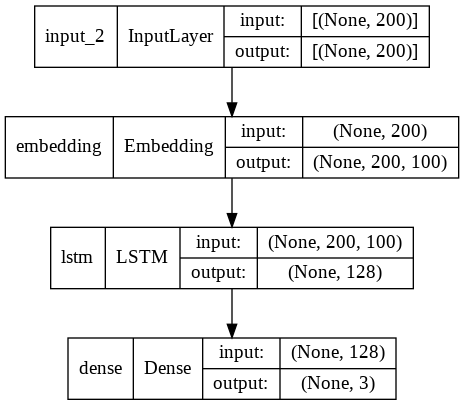

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

You can see that the model has 1 input layer, 1 embedding layer, 1 LSTM, and one dense layer which serves as the output layer as well.

Let's now train our model:

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
87/87 [==============================] - 10s 58ms/step - loss: 0.8622 - acc: 0.6581 - val_loss: 0.8381 - val_acc: 0.6589
Epoch 2/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8332 - acc: 0.6627 - val_loss: 0.8361 - val_acc: 0.6593
Epoch 3/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8180 - acc: 0.6676 - val_loss: 0.8373 - val_acc: 0.6600
Epoch 4/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8173 - acc: 0.6684 - val_loss: 0.8228 - val_acc: 0.6658
Epoch 5/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8174 - acc: 0.6688 - val_loss: 0.8397 - val_acc: 0.6615
Epoch 6/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8169 - acc: 0.6675 - val_loss: 0.8316 - val_acc: 0.6636
Epoch 7/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8117 - acc: 0.6713 - val_loss: 0.8292 - val_acc: 0.6626
Epoch 8/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8052 - 

Let's now evaluate the performance of our model on test set:

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

108/108 [==============================] - 2s 18ms/step - loss: 0.9346 - acc: 0.6733
Test Score: 0.9345514178276062
Test Accuracy: 0.6733275651931763


Finally, let's plot the values for loss and accuracy for both training and testing sets:

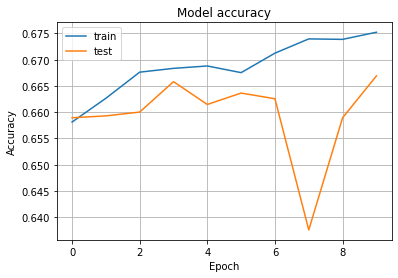

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Model accuracy')
  plt.legend(['train','test'], loc='upper left')
  plt.grid(True)
  plt.show()

plot_accuracy(history)

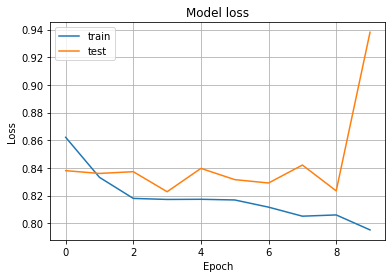

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Model loss')
  plt.legend(['train','test'], loc='upper left')
  plt.grid(True)
  plt.show()

plot_loss(history)

## Create modell with metadata

In the previous sections, we saw how to train deep learning models using either textual data or meta information. What if we want to combine textual information with meta information and use that as input to our model? We can do so using the Keras functional API. In this section we will create two submodels.

The first submodel will accept textual input in the form of text reviews. This submodel will consist of an input shape layer, an embedding layer, and an LSTM layer of 128 neurons. The second submodel will accept input in the form of meta information from the useful, funny, and cool columns. The second submodel also consist of three layers. An input layer and two dense layers.

The output from the LSTM layer of the first submodel and the output from the second dense layer of the second submodel will be concatenated together and will be used as concatenated input to another dense layer with 10 neurons. Finally, the output dense layer will have three neuorns corresponding to each review type.

Let's see how we can createe such a concatenated model.

First we have to create two different types of inputs. To do so, we will divide our data into a feature set and label set, as shown below:

In [ ]:
X = yelp_reviews.drop('reviews_score', axis=1)

y = yelp_reviews['reviews_score']

In [ ]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y = label_encoder.fit_transform(y)

# ------------------>

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

from tensorflow.keras.utils import to_categorical

# ------------------>
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Now our label set is in the required form. Since there will be only one output, therefore we don't need to process our label set. However, there will be multiple inputs to the model. Therefore, we need to preprocess our feature set.

Let's first create preproces_text function that will be used to preprocess our dataset:

In [ ]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

As a first step, we will create textual input for the training and test set. Look at the following script:

In [ ]:
X1_train = []
sentences = list(X_train["text"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))

Now X1_train contains the textual input for the training set. Similarly, the following script preprocess textual input data for test set:

In [ ]:
X1_test = []
sentences = list(X_test["text"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))

Now we need to convert textual input for the training and test sets into numeric form using word embeddings. The following script does that:

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

We will again use GloVe word embeddings for creating word vectors:

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

We have preprocessed our textual input. The second input type is the meta information in the useful, funny, and cool columns. We will filter these columns from the feature set to create meta input for training the algorithms. Look at the following script:

In [ ]:
X2_train = X_train[['useful', 'funny', 'cool']].values
X2_test = X_test[['useful', 'funny', 'cool']].values

Let's now create our two input layers. The first input layer will be used to input the textual input and the second input layer will be used to input meta information from the three columns.

In [ ]:
input_1 = Input(shape=(maxlen,))

input_2 = Input(shape=(3,))

You can see that the first input layer input_1 is used for the textual input. The shape size has been set to the shape of the input sentence. For the second input layer, the shape corresponds to three columns.

Let's now create the first submodel that accepts data from first input layer:

In [ ]:
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

Similarly, the following script creates a second submodel that accepts input from the second input layer:

In [ ]:
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

We now have two submodels. What we want to do is concatenate the output from the first submodel with the output from the second submodel. The output from the first submodel is the output from the LSTM_Layer_1 and similarly, the output from the second submodel is the output from the dense_layer_2. We can use the Concatenate class from the keras.layers.merge module to concatenate two inputs.

The following script creates our final model:

In [ ]:
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)

You can see that now our model has a list of inputs with two items. The following script compiles the model and prints its summary:

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 100)     3486100     ['input_3[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 10)           40          ['input_4[0][0]']                
                                                                                            

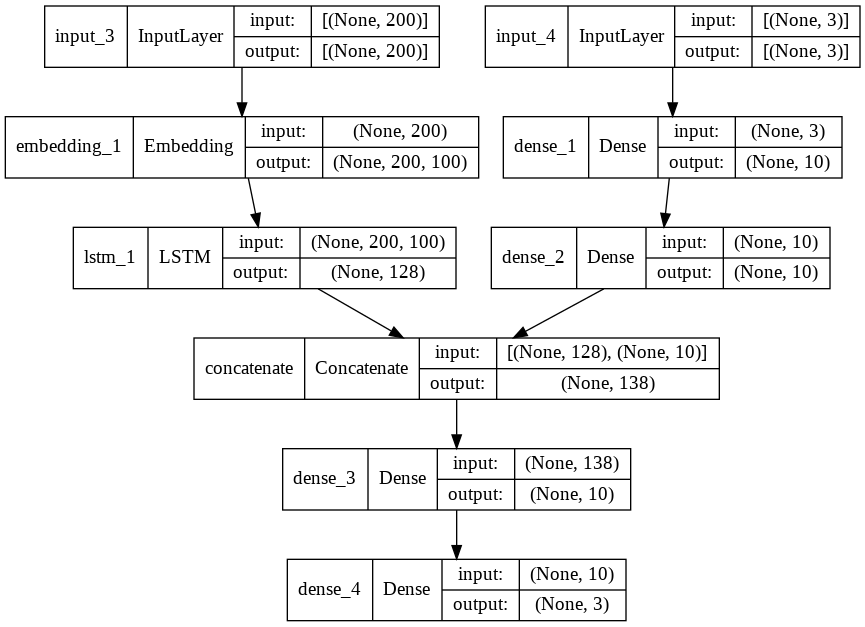

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)

The above figure clearly explains how we have concatenated multiple inputs into one input to create our model.

Let's now train our model and see the results:

In [ ]:
history = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
87/87 [==============================] - 7s 56ms/step - loss: 0.8697 - acc: 0.6562 - val_loss: 0.8282 - val_acc: 0.6582
Epoch 2/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8621 - acc: 0.6594 - val_loss: 0.8390 - val_acc: 0.6597
Epoch 3/10
87/87 [==============================] - 4s 47ms/step - loss: 0.8166 - acc: 0.6646 - val_loss: 0.8212 - val_acc: 0.6597
Epoch 4/10
87/87 [==============================] - 4s 48ms/step - loss: 0.8045 - acc: 0.6659 - val_loss: 0.8104 - val_acc: 0.6629
Epoch 5/10
87/87 [==============================] - 4s 48ms/step - loss: 0.7930 - acc: 0.6699 - val_loss: 0.7980 - val_acc: 0.6698
Epoch 6/10
87/87 [==============================] - 4s 47ms/step - loss: 0.7827 - acc: 0.6730 - val_loss: 0.7892 - val_acc: 0.6658
Epoch 7/10
87/87 [==============================] - 4s 47ms/step - loss: 0.7744 - acc: 0.6735 - val_loss: 0.7773 - val_acc: 0.6687
Epoch 8/10
87/87 [==============================] - 4s 48ms/step - loss: 0.7275 - a

In [ ]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

108/108 [==============================] - 2s 14ms/step - loss: 0.6134 - acc: 0.7376
Test Score: 0.6134420037269592
Test Accuracy: 0.7376194596290588


Our test accuracy is 80.53%, which is slightly less than our first model that uses textual input only. This shows that meta information in yelp_reviews is not very useful for sentiment prediction.

Anyways, now you know how to create multiple input model for text classification in Keras!

Finally, let's now print the loss and accuracy for training and test sets:

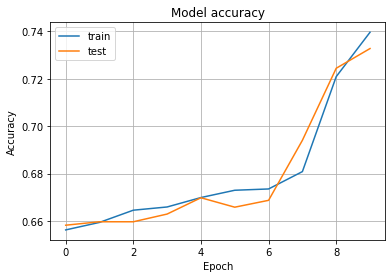

In [ ]:
plot_accuracy(history)

## Final Thoughts and Improvements
In this article, we built a very simple neural network since the purpose of the article is to explain how to create deep learning model that accepts multiple inputs of different types.

Following are some of the tips that you can follow to further improve the performance of the text classification model:

We only used 50,000, out of 5.2 million records in this article since we had hardware constraint. You can try training your model on a higher number of records and see if you can achieve better performance.
Try adding more LSTM and dense layers to the model. If the model overfits, try to add dropout.
Try to change the optimizer function and train the model with higher number of epochs.
Please share your results along with the neural network configuration in the comments section. I would love to see how well did you perform.

In [ ]:
# https://en.wikipedia.org/wiki/Stochastic_gradient_descent

# arra az esetre, ha meg akarok őrülni

In [ ]:
# https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/

# ez is olyan ami alapján lehet cikket írni, alapanyag

In [ ]:

# https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/


# olvastam egy sexy cikket
# a batch_size jelentőségéről

# van ahol a batch size nagyon kicsi (n=1 -> sgd), de van olyan is, hogy teljes mintát odaadja neki

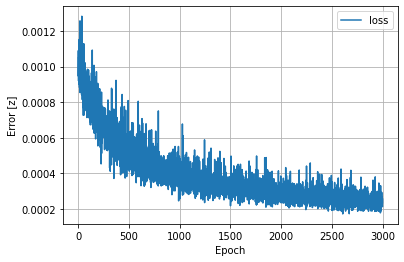

In [ ]:
model.save('woman1')

INFO:tensorflow:Assets written to: woman1/assets


In [ ]:
!zip -r woman1.zip woman1

  adding: woman1/ (stored 0%)
  adding: woman1/assets/ (stored 0%)
  adding: woman1/keras_metadata.pb (deflated 89%)
  adding: woman1/saved_model.pb (deflated 89%)
  adding: woman1/variables/ (stored 0%)
  adding: woman1/variables/variables.data-00000-of-00001 (deflated 64%)
  adding: woman1/variables/variables.index (deflated 64%)


In [ ]:
!rm -rf woman1

In [ ]:
!wget https://github.com/JoDeMiro/Face/raw/main/woman1.zip

In [ ]:
!unzip woman1.zip

Archive:  woman1.zip
   creating: woman1/
   creating: woman1/assets/
  inflating: woman1/keras_metadata.pb  
  inflating: woman1/saved_model.pb   
   creating: woman1/variables/
  inflating: woman1/variables/variables.data-00000-of-00001  
  inflating: woman1/variables/variables.index  


In [ ]:
model = keras.models.load_model('woman1')

In [ ]:
y_predicted = model.predict(input)

y_predicted[0:10]

array([[1.008, 0.964, 0.876],
       [1.007, 0.963, 0.875],
       [1.007, 0.963, 0.876],
       [1.007, 0.963, 0.877],
       [1.006, 0.963, 0.878],
       [1.006, 0.963, 0.879],
       [1.006, 0.963, 0.88 ],
       [1.006, 0.963, 0.881],
       [1.006, 0.963, 0.882],
       [1.006, 0.963, 0.882]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


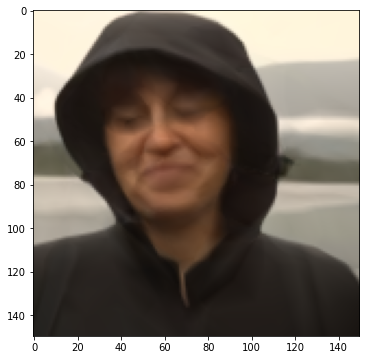

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


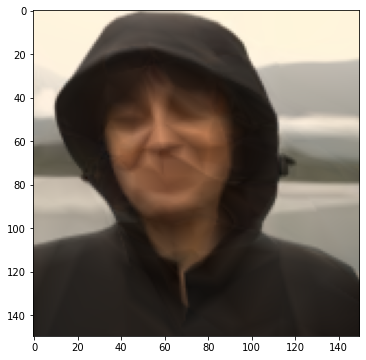

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(y_predicted_retransformed)
plt.show()